# Machine Learning

For the machine learning portion of the project, we decided to use `KNeighborsRegressor`, `LinearRegression`, and `RandomForestRegressor` models to see which combination of features and parameters would yield the best test and validation error.

In [34]:
# Import statements
%matplotlib inline
import numpy as np
import pandas as pd
import itertools
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

After reading in the dataframe created from the first notebook, we split it into training and test dataframes. The test dataframe that we would predict on had player information for the `2017` season, and the training dataframe has player information from `2008 - 2016`

In [39]:
# Create the training dataset (2008 - 2017)
final_df = pd.read_csv("/Users/lhan/Desktop/Senior/DATA301/project/player.csv")
player_df = final_df[final_df["season"] != 2017].reset_index().drop(columns=["index"])
test_df = final_df[final_df["season"] == 2017].reset_index().drop(columns=["index"])
player_df

,name,season,age,team_id,pos,g,gs,mp_per_g,fg_pct,fg3_pct,...,orb_per_g,drb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g,height,weight
0,Alex Abrines,2016.0,23.0,OKC,SG,68.0,6.0,15.5,0.393,0.381,...,0.3,1.0,0.6,0.5,0.1,0.5,1.7,6.0,78,200.0
1,Alex Acker,2008.0,26.0,DET,SG,7.0,0.0,2.9,0.364,0.000,...,0.0,0.3,0.1,0.3,0.1,0.0,0.0,1.3,77,185.0
2,Alex Acker,2008.0,26.0,LAC,SG,18.0,0.0,9.9,0.400,0.438,...,0.4,0.8,0.6,0.2,0.2,0.4,0.5,3.5,77,185.0
3,Quincy Acy,2012.0,22.0,TOR,PF,29.0,0.0,11.8,0.560,0.500,...,1.0,1.6,0.4,0.4,0.5,0.6,1.8,4.0,79,240.0
4,Quincy Acy,2013.0,23.0,TOR,SF,7.0,0.0,8.7,0.429,0.400,...,0.7,1.4,0.6,0.6,0.4,0.3,1.1,2.7,79,240.0
5,Quincy Acy,2013.0,23.0,SAC,SF,56.0,0.0,14.0,0.472,0.200,...,1.2,2.4,0.4,0.3,0.4,0.5,2.0,2.7,79,240.0
6,Quincy Acy,2014.0,24.0,NYK,PF,68.0,22.0,18.9,0.459,0.300,...,1.2,3.3,1.0,0.4,0.3,0.9,2.2,5.9,79,240.0
7,Quincy Acy,2015.0,25.0,SAC,PF,59.0,29.0,14.8,0.556,0.388,...,1.1,2.1,0.5,0.5,0.4,0.5,1.7,5.2,79,240.0
8,Quincy Acy,2016.0,26.0,DAL,PF,6.0,0.0,8.0,0.294,0.143,...,0.3,1.0,0.0,0.0,0.0,0.3,1.5,2.2,79,240.0
9,Quincy Acy,2016.0,26.0,BRK,PF,32.0,1.0,15.9,0.425,0.434,...,0.6,2.8,0.6,0.4,0.5,0.6,1.8,6.5,79,240.0


### Model and feature selection:

In [40]:
# Features that are correlated to average points per game
features = ["name", "height", "weight", "pos", "g", "mp_per_g", "efg_pct", "ft_pct"]

# creating a power set of all possible feature combinations
list_of_features = []
for n in range(1, len(features)+1):
    combination = [list(i) for i in itertools.combinations(features, n)]
    list_of_features.extend(combination)

In [41]:
y = player_df["pts_per_g"]
vec = DictVectorizer(sparse=False)
scaler = StandardScaler()

In [42]:
# Function that determines the best combination of features
def find_best_features(model, list_of_features, y):
    # Set up the pipeline
    pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", model)])
    
    # Create a dictionary of features and its respective rmse value
    dictionary = {}
    for features in list_of_features:
        X_dict = player_df[features].to_dict(orient="records")
        scores = cross_val_score(pipeline, X_dict, y, cv=10, scoring="neg_mean_squared_error")
        rmse = np.sqrt(np.mean(-scores))
        dictionary.update({str(features):rmse})
    return dictionary

In [ ]:
# Evaluate the model with the best set of features and lowest RMSE
list_of_models = [RandomForestRegressor(n_estimators = 10), 
                  KNeighborsRegressor(n_neighbors = 10),
                  LinearRegression()]
for model in list_of_models:
    dictionary = find_best_features(model, list_of_features, y)
    min_rmse = min(dictionary.items(), key=lambda x: x[1]) 
    print("Model: " + str(model))
    print("Best features: " + min_rmse[0])
    print("RMSE value: " + str(min_rmse[1]) + "\n")

**Regression Ensembler:**

We will utilize the `RegressionEnsembler` class that Professor Sun provided to us and see if we can get a better result combining two models with the lowest rmse values.

In [14]:
class RegressionEnsembler(BaseEstimator, RegressorMixin):
    def __init__(self, estimators, learn_weights=True):
        self.estimators = estimators
        self.learn_weights = learn_weights
        
    def fit(self, X, y):
        # check that X and y have the correct shape
        X, y = check_X_y(X, y)
        
        # store the training features and the labels
        self.X_ = X
        self.y_ = y
        
        # call the fit method of each of the estimators
        for estimator in self.estimators:
            estimator.fit(X, y)
            
        # if we wish to learn the "optimal" weights from the training data
        if self.learn_weights:
            # get prediction from each estimator on the training data
            predictions = []
            for estimator in self.estimators:
                predictions.append(estimator.predict(X))
            Y_ = np.column_stack(predictions)
        
            # fit linear regression on top of the estimators' predictions
            self.ensembler = LinearRegression(fit_intercept=False)
            self.ensembler.fit(Y_, y)
            
        return self
    
    def predict(self, X):
        # check that fit has been called
        check_is_fitted(self, ['X_', 'y_'])
        
        # check that X has the right form
        X = check_array(X)
        
        # calculate predictions from the estimators
        predictions = []
        for estimator in self.estimators:
            predictions.append(estimator.predict(X))
        Y_ = np.column_stack(predictions)
        
        # return predictions
        if self.learn_weights:
            return self.ensembler.predict(Y_)
        else:
            return Y_.mean(axis=1)

In [15]:
# Evaluate the ensembler model with the best set of features and lowest RMSE
model = RegressionEnsembler([RandomForestRegressor(n_estimators = 10), 
                             KNeighborsRegressor(n_neighbors = 10)])
dictionary = find_best_features(model, list_of_features, y)
min_rmse = min(dictionary.items(), key=lambda x: x[1]) 
print("Model: " + str(model))
print("Best features: " + min_rmse[0])
print("RMSE value: " + str(min_rmse[1]) + "\n")

Model: RegressionEnsembler(estimators=[RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estima...wski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')],
          learn_weights=True)
Best features: ['name', 'height', 'weight', 'team_id', 'g', 'mp_per_g', 'ft_pct']
RMSE value: 2.260386347316284



It appears that the `RandomForestRegressor` model with `['name', 'height', 'weight', 'mp_per_g', 'fg_pct']` as the features yields the lowest `rmse` of `~2.306`.

### Hyperparameter Tuning:

Using the best model and set of features, we will now determine the best scaler methods. Then, we will determine the best hyperparameters for the `RandomForestRegressor` model.

In [16]:
list_of_scaler = [StandardScaler(), Normalizer(), MinMaxScaler(), RobustScaler()]
best_features = ['name', 'height', 'pos', 'mp_per_g', 'fg_pct', 'ft_pct']
# Function that determines the best scaler method
def find_best_scaler(model, list_of_scaler, y):
    # Set up the pipeline
    
    # Create a dictionary of features and its respective rmse value
    dictionary = {}
    for scaler in list_of_scaler:
        pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", model)])
        X_dict = player_df[best_features].to_dict(orient="records")
        scores = cross_val_score(pipeline, X_dict, y, cv=10, scoring="neg_mean_squared_error")
        rmse = np.sqrt(np.mean(-scores))
        dictionary.update({str(scaler):rmse})
    return dictionary

In [18]:
model = RandomForestRegressor(n_estimators = 10)
dictionary = find_best_scaler(model, list_of_scaler, y)
min_rmse = min(dictionary.items(), key=lambda x: x[1]) 
print("Model: " + str(model))
print("Best scaler: " + min_rmse[0])
print("RMSE value: " + str(min_rmse[1]) + "\n")

Model: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Best scaler: MinMaxScaler(copy=True, feature_range=(0, 1))
RMSE value: 2.2620661110727163



### Train Error vs. Validation Error:

We will determine what the best value for `n_estimators` is by calculating the training error and validation error using the `RobustScaler`, `best_features`.

In [21]:
vec = DictVectorizer(sparse=False)
scaler = MinMaxScaler()

# Calculates estimate of test error based on 10-fold cross validation
def val_error(k):
    model = RandomForestRegressor(n_estimators = k)
    pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", model)])
    X_dict = player_df[best_features].to_dict(orient="records")
    scores = cross_val_score(pipeline, X_dict, y, cv=10, scoring="neg_mean_squared_error")
    rmse = np.sqrt(np.mean(-scores))
    return rmse

# Calculates the train error based on 10-fold cross validation
def train_error(k):
    X_dict = player_df[best_features].to_dict(orient="records")
    vec.fit(X_dict)
    X_train = vec.transform(X_dict)
    scaler.fit(X_train)
    X_train_sc = scaler.transform(X_train)
    
    model = RandomForestRegressor(n_estimators = k)
    model.fit(X_train_sc, y)

    y_train_pred = model.predict(X_train_sc)
    rmse = np.sqrt(((y - y_train_pred) ** 2).mean())
    return rmse

Best value for n_estimators: 49


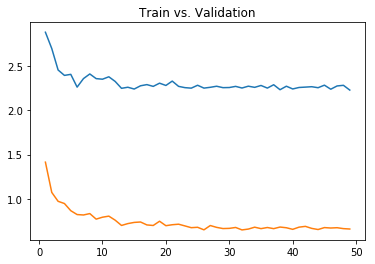

In [22]:
# Plot train and validation error
ks = pd.Series(range(1,50))
ks.index = range(1,50)
test_errs = ks.apply(lambda m: val_error(m))
test_errs.plot.line()
train_errs = ks.apply(lambda m: train_error(m))
train_errs.plot.line(title = "Train vs. Validation")
print("Best value for n_estimators: " + str(test_errs.sort_values().idxmin()))

### Predicting average points per game in 2017:

In [23]:
unknown_df = test_df

In [24]:
unknown_df["pts_per_g"] = np.nan
unknown_df.head()

,name,season,age,team_id,pos,g,gs,mp_per_g,fg_pct,fg3_pct,...,orb_per_g,drb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g,height,weight
0,Alex Abrines,2017.0,24.0,OKC,SG,75.0,8.0,15.1,0.395,0.380,...,0.3,1.2,0.4,0.5,0.1,0.3,1.7,NaN,78,200.0
1,Quincy Acy,2017.0,27.0,BRK,PF,70.0,8.0,19.4,0.356,0.349,...,0.6,3.1,0.8,0.5,0.4,0.9,2.1,NaN,79,240.0
2,Steven Adams,2017.0,24.0,OKC,C,76.0,76.0,32.7,0.629,0.000,...,5.1,4.0,1.2,1.2,1.0,1.7,2.8,NaN,84,265.0
3,Bam Adebayo,2017.0,20.0,MIA,C,69.0,19.0,19.8,0.512,0.000,...,1.7,3.8,1.5,0.5,0.6,1.0,2.0,NaN,82,255.0
4,Arron Afflalo,2017.0,32.0,ORL,SG,53.0,3.0,12.9,0.401,0.386,...,0.1,1.2,0.6,0.1,0.2,0.4,1.1,NaN,77,210.0


In [25]:
X_dict = player_df[best_features].to_dict(orient="records")
X_new_dict = unknown_df[best_features].to_dict(orient="records")
y = player_df["pts_per_g"]

scaler = RobustScaler()
model = RandomForestRegressor(n_estimators = 48)

vec.fit(X_dict)
X_train = vec.transform(X_dict)
X_new = vec.transform(X_new_dict)

scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_new_sc = scaler.transform(X_new)

model.fit(X_train_sc, y)

unknown_df["pts_per_g"] = model.predict(X_new_sc)

In [26]:
unknown_df

,name,season,age,team_id,pos,g,gs,mp_per_g,fg_pct,fg3_pct,...,orb_per_g,drb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g,height,weight
0,Alex Abrines,2017.0,24.0,OKC,SG,75.0,8.0,15.1,0.395,0.380,...,0.3,1.2,0.4,0.5,0.1,0.3,1.7,6.158333,78,200.0
1,Quincy Acy,2017.0,27.0,BRK,PF,70.0,8.0,19.4,0.356,0.349,...,0.6,3.1,0.8,0.5,0.4,0.9,2.1,5.487500,79,240.0
2,Steven Adams,2017.0,24.0,OKC,C,76.0,76.0,32.7,0.629,0.000,...,5.1,4.0,1.2,1.2,1.0,1.7,2.8,12.860417,84,265.0
3,Bam Adebayo,2017.0,20.0,MIA,C,69.0,19.0,19.8,0.512,0.000,...,1.7,3.8,1.5,0.5,0.6,1.0,2.0,6.783333,82,255.0
4,Arron Afflalo,2017.0,32.0,ORL,SG,53.0,3.0,12.9,0.401,0.386,...,0.1,1.2,0.6,0.1,0.2,0.4,1.1,4.464583,77,210.0
5,Cole Aldrich,2017.0,29.0,MIN,C,21.0,0.0,2.3,0.333,0.000,...,0.1,0.6,0.1,0.1,0.0,0.0,0.5,1.045833,83,250.0
6,LaMarcus Aldridge,2017.0,32.0,SAS,C,75.0,75.0,33.5,0.510,0.293,...,3.3,5.2,2.0,0.6,1.2,1.5,2.1,18.372917,83,260.0
7,Jarrett Allen,2017.0,19.0,BRK,C,72.0,31.0,20.0,0.589,0.333,...,2.0,3.4,0.7,0.4,1.2,1.1,2.0,6.847917,83,237.0
8,Kadeem Allen,2017.0,25.0,BOS,PG,18.0,1.0,5.9,0.273,0.000,...,0.2,0.4,0.7,0.2,0.1,0.5,0.8,1.635417,75,192.0
9,Tony Allen,2017.0,36.0,NOP,SF,22.0,0.0,12.4,0.484,0.333,...,0.9,1.2,0.4,0.5,0.1,0.9,2.2,4.256250,76,213.0


In [27]:
test_df = final_df[final_df["season"] == 2017].reset_index().drop(columns=["index"])
test_df

,name,season,age,team_id,pos,g,gs,mp_per_g,fg_pct,fg3_pct,...,orb_per_g,drb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g,height,weight
0,Alex Abrines,2017.0,24.0,OKC,SG,75.0,8.0,15.1,0.395,0.380,...,0.3,1.2,0.4,0.5,0.1,0.3,1.7,4.7,78,200.0
1,Quincy Acy,2017.0,27.0,BRK,PF,70.0,8.0,19.4,0.356,0.349,...,0.6,3.1,0.8,0.5,0.4,0.9,2.1,5.9,79,240.0
2,Steven Adams,2017.0,24.0,OKC,C,76.0,76.0,32.7,0.629,0.000,...,5.1,4.0,1.2,1.2,1.0,1.7,2.8,13.9,84,265.0
3,Bam Adebayo,2017.0,20.0,MIA,C,69.0,19.0,19.8,0.512,0.000,...,1.7,3.8,1.5,0.5,0.6,1.0,2.0,6.9,82,255.0
4,Arron Afflalo,2017.0,32.0,ORL,SG,53.0,3.0,12.9,0.401,0.386,...,0.1,1.2,0.6,0.1,0.2,0.4,1.1,3.4,77,210.0
5,Cole Aldrich,2017.0,29.0,MIN,C,21.0,0.0,2.3,0.333,0.000,...,0.1,0.6,0.1,0.1,0.0,0.0,0.5,0.6,83,250.0
6,LaMarcus Aldridge,2017.0,32.0,SAS,C,75.0,75.0,33.5,0.510,0.293,...,3.3,5.2,2.0,0.6,1.2,1.5,2.1,23.1,83,260.0
7,Jarrett Allen,2017.0,19.0,BRK,C,72.0,31.0,20.0,0.589,0.333,...,2.0,3.4,0.7,0.4,1.2,1.1,2.0,8.2,83,237.0
8,Kadeem Allen,2017.0,25.0,BOS,PG,18.0,1.0,5.9,0.273,0.000,...,0.2,0.4,0.7,0.2,0.1,0.5,0.8,1.1,75,192.0
9,Tony Allen,2017.0,36.0,NOP,SF,22.0,0.0,12.4,0.484,0.333,...,0.9,1.2,0.4,0.5,0.1,0.9,2.2,4.7,76,213.0
